In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import sys
import matplotlib.pyplot as plt
from collections import Counter

# Calculate metrics
from sklearn.metrics import r2_score, mean_absolute_error


# Add the models directory to the python path
sys.path.append("models")
from mlp_model import SimpleMLP

# Import the helper functions from our model file
from mlp_model import create_data_loaders, train_epoch, validate

## Load and Explore Gene Expression Data

The counts data contains gene expression measurements for different drug treatments.

In [ ]:
# Load metadata to get drug information
compounds = pd.read_csv("./data/unique_compounds.csv")
counts_df = pd.read_csv(
    "./data/MCE_Bioactive_Compounds_HEK293T_10μM_Counts.csv", index_col=0, skiprows=1
)
metadata_df = pd.read_csv(
    "./data/MCE_Bioactive_Compounds_HEK293T_10μM_MetaData.csv", skiprows=1
)
print(f"Number of samples: {len(metadata_df)}")
print(f"Number of genes: {counts_df.shape[1]}")
print(f"\nMetadata columns: {metadata_df.columns.tolist()}")
print("\nFirst few drug treatments:")
print(metadata_df[["treatment", "sample"]].head(10))

Number of samples: 40778
Number of genes: 3407

Metadata columns: ['unique_ID', 'experiment_no', 'sample_plate', 'sample_row', 'sample_column', 'cell_id', 'pert_itime', 'pert_idose', 'sample', 'treatment']

First few drug treatments:
   treatment     sample
0   HY_50946   HY_50946
1   HY_18686   HY_18686
2  HY_17592A  HY_17592A
3   HY_19411   HY_19411
4   HY_18522   HY_18522
5   HY_17439   HY_17439
6   HY_18061   HY_18061
7       DMSO    DMSO_03
8  HY_19928A  HY_19928A
9   HY_18669   HY_18669


In [ ]:
embeddings = pd.read_csv("data/molformer-embeddings.csv")
embeddings

,CID,CAS,smiles,0,1,2,3,4,5,6,...,758,759,760,761,762,763,764,765,766,767
0,205912,18979-61-8,CCCCC1=C(C=C(C=C1)O)O,0.985253,-0.414438,-0.363742,0.622728,-1.328449,-0.324084,-0.641040,...,0.767878,0.810009,-0.503663,0.985284,-0.176481,-0.664044,-0.132383,0.125016,0.297582,0.735747
1,71532921,1429651-50-2,C1=CC=C(C=C1)N(CCO)C(=O)CC2=CC=C(C=C2)C(=O)NO,-0.287197,-0.722552,-0.718126,-0.236562,-1.115782,-0.531389,-1.278204,...,0.422765,0.519235,-0.135786,-0.071139,-0.080451,-0.388809,-1.724904,0.057771,-0.534797,0.041896
2,644215,164658-13-3,C1=CC(=CC(=C1)Cl)NC2=NC=CC(=N2)C3=CC(=NC=C3)NCCCO,-0.182793,-0.575912,-0.566026,0.463177,-0.747919,-0.133567,-0.460694,...,0.553366,0.201456,-0.415808,0.066159,-0.294800,-0.380439,-1.920309,-0.039560,-1.106062,-0.129032
3,134128281,2309668-15-1,C1=CC(=CC=C1CO)[C@@H](CN)C(=O)NC2=CC3=C(C=C2)C...,-0.150467,-0.206697,-0.575187,0.074890,-1.097889,-0.845826,-0.927723,...,0.666575,0.389585,0.147568,-0.148481,0.153590,-0.205970,-1.729240,-0.107210,-0.782025,0.112719
4,138454775,2235358-74-2,CNC1=NC=CC(=N1)CN(C2CCC(CC2)N)S(=O)(=O)C3=CC=C...,0.306828,-0.736981,-0.447893,0.494913,-0.529202,-0.574852,-0.641105,...,0.494807,0.747837,0.614527,0.145446,-0.491479,-0.256579,-1.946391,-0.606912,-0.096466,0.018026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2374,56970858,1373765-19-5,COC1=NC(=NC=C1)N2CCC3(CCCN(C3=O)CC4=CNC5=CC=CC...,0.594084,0.241800,0.061521,0.398166,-0.523359,0.018218,-0.518841,...,-0.374233,0.462094,-0.076321,0.466713,0.331940,-0.455478,-2.999456,-0.281490,-0.756438,-0.443556
2375,46861897,874484-20-5,COC1=NC2=C(C=C1)N3CC4=C(C3=C2CCNC(=O)C5=CC=CO5...,0.683878,0.062158,0.541062,0.401861,-0.102901,0.076197,-0.537647,...,-0.146895,0.425641,0.079641,0.524890,0.517666,-0.573386,-2.358849,-0.352562,-0.681536,-0.531223
2376,53245636,900185-01-5,CC1=C2C(=CC=C1)N=C(N(C2=O)C3=CC=CC=C3C)CN4C5=N...,0.729048,0.051865,0.223849,0.365191,-0.668336,-0.111063,-0.396522,...,-0.262879,0.575145,-0.234254,0.888520,0.317051,-0.308241,-2.980067,-0.165158,-0.732087,-0.394751
2377,44968267,1228817-38-6,CCOC1=C(C=CC(=C1)N2CCC(CC2)O)NC3=NC=C4C(=N3)N(...,0.099331,-0.047744,0.258372,0.093163,-0.322585,0.200407,-0.373826,...,-0.327709,0.654967,-0.125509,0.752127,0.156419,-0.438584,-3.248656,-0.053201,-0.352933,-0.271986


## Prepare Data Structure for Model

Now we'll use pre-computed MolFormer embeddings (768-dimensional) instead of Morgan fingerprints.

In [ ]:
# Load MolFormer embeddings
embeddings = pd.read_csv("data/molformer-embeddings.csv")

# Extract only the embedding columns (0 to 767)
embedding_columns = [str(i) for i in range(768)]
embeddings_matrix = embeddings[embedding_columns].values

# Create mapping from CID to embedding
cid_to_embedding = dict(zip(embeddings["CID"], embeddings_matrix))

print(f"Loaded embeddings for {len(cid_to_embedding)} compounds")
print(f"Embedding dimension: {len(embedding_columns)}")
print(f"\nFirst few CIDs: {list(cid_to_embedding.keys())[:5]}")

Loaded embeddings for 2245 compounds
Embedding dimension: 768

First few CIDs: [205912, 71532921, 644215, 134128281, 138454775]


In [ ]:
# Create a mapping from Catalog Number to CID
catalog_to_cid = dict(zip(compounds["Catalog Number"], compounds["CID"]))
print(f"Number of compounds with CID: {len(catalog_to_cid)}")

# Check some examples
print("\nExample mappings (Catalog Number -> CID):")
for i, (cat_num, cid) in enumerate(list(catalog_to_cid.items())[:3]):
    print(f"  {cat_num}: {cid}")
    if i >= 2:
        break

Number of compounds with CID: 2519

Example mappings (Catalog Number -> CID):
  HY_107369: 205912.0
  HY_19747: 71532921.0
  HY_11009: 644215.0


In [ ]:
# Get unique drugs (excluding DMSO controls)
drug_treatments = metadata_df[metadata_df["treatment"] != "DMSO"]["treatment"].unique()
print(f"Number of unique drugs in metadata: {len(drug_treatments)}")

# Check how many drugs have embeddings
# First map Catalog Number to CID, then check if CID has embeddings
drugs_with_embeddings = []
drugs_without_embeddings = []

for drug in drug_treatments:
    cid = catalog_to_cid.get(drug)
    if cid is not None and cid in cid_to_embedding:
        drugs_with_embeddings.append(drug)
    else:
        drugs_without_embeddings.append(drug)

print(f"Drugs with MolFormer embeddings: {len(drugs_with_embeddings)}")
print(f"Drugs without embeddings: {len(drugs_without_embeddings)}")

if drugs_without_embeddings:
    print(f"\nWarning: {len(drugs_without_embeddings)} drugs do not have embeddings")
    print(f"First few missing: {drugs_without_embeddings[:5]}")

# Filter to only use drugs with embeddings
drug_treatments_filtered = drugs_with_embeddings
print(
    f"\nUsing {len(drug_treatments_filtered)} drugs with MolFormer embeddings for training"
)

Number of unique drugs in metadata: 11360
Drugs with MolFormer embeddings: 2248
Drugs without embeddings: 9112

First few missing: ['HY_50946', 'HY_18686', 'HY_17439', 'HY_18061', 'HY_18669']

Using 2248 drugs with MolFormer embeddings for training


In [ ]:
# Get MolFormer embeddings for each drug
print("Retrieving MolFormer embeddings for drugs...")

num_drug_features = 768  # MolFormer embedding dimension
drug_descriptor_dict = {}
failed_drugs = []

for drug_id in drug_treatments_filtered:
    cid = catalog_to_cid.get(drug_id)
    if cid and cid in cid_to_embedding:
        drug_descriptor_dict[drug_id] = cid_to_embedding[cid]
    else:
        failed_drugs.append(drug_id)

print(f"✓ Successfully retrieved embeddings for {len(drug_descriptor_dict)} drugs")
if failed_drugs:
    print(f"✗ Failed to retrieve embeddings for {len(failed_drugs)} drugs")

# Show statistics
all_embeddings = np.array(list(drug_descriptor_dict.values()))
print("\nEmbedding statistics:")
print(f"  Shape: {all_embeddings.shape}")
print(f"  Mean: {all_embeddings.mean():.3f}")
print(f"  Std: {all_embeddings.std():.3f}")
print(f"  Min: {all_embeddings.min():.3f}")
print(f"  Max: {all_embeddings.max():.3f}")

Retrieving MolFormer embeddings for drugs...
✓ Successfully retrieved embeddings for 2248 drugs

Embedding statistics:
  Shape: (2248, 768)
  Mean: 0.003
  Std: 0.796
  Min: -7.258
  Max: 16.711


In [ ]:
# Prepare gene expression data (target) - only for drugs with embeddings
# Filter to only include drug-treated samples (not DMSO) AND drugs with embeddings
valid_drugs_mask = metadata_df["treatment"].isin(drug_treatments_filtered)
drug_sample_ids = metadata_df[valid_drugs_mask]["unique_ID"].values
drug_ids = metadata_df[valid_drugs_mask]["treatment"].values

# Get gene expression data for valid samples
gene_expression_data = counts_df.loc[drug_sample_ids].values

print(f"Gene expression data shape: {gene_expression_data.shape}")
print(
    f"(n_samples, n_genes) = ({gene_expression_data.shape[0]}, {gene_expression_data.shape[1]})"
)

# Map each sample to its drug descriptors (MolFormer embeddings)
drug_features = np.array([drug_descriptor_dict[drug_id] for drug_id in drug_ids])
print(f"\nDrug features shape: {drug_features.shape}")
print(f"(n_samples, n_features) = ({drug_features.shape[0]}, {drug_features.shape[1]})")

print("\n✓ Data preparation complete!")
print(f"  Total samples: {len(drug_sample_ids)}")
print(f"  Unique drugs: {len(set(drug_ids))}")
print(f"  Features per drug: {num_drug_features} (MolFormer embeddings)")
print(f"  Genes to predict: {gene_expression_data.shape[1]}")

Gene expression data shape: (6744, 3407)
(n_samples, n_genes) = (6744, 3407)

Drug features shape: (6744, 768)
(n_samples, n_features) = (6744, 768)

✓ Data preparation complete!
  Total samples: 6744
  Unique drugs: 2248
  Features per drug: 768 (MolFormer embeddings)
  Genes to predict: 3407


### Understanding Samples vs Drugs

**Important distinction:**
- **Unique drugs**: ~2,248 compounds with embeddings
- **Total samples**: ~6,744 measurements

Each drug has **multiple replicates** (repeated measurements). The model sees each replicate as a separate training example, but all replicates of the same drug use the **same embedding vector**.

In [ ]:
# Let's verify this - count samples per drug

samples_per_drug = Counter(drug_ids)
num_unique_drugs = len(samples_per_drug)
total_samples = len(drug_ids)

print("Statistics:")
print(f"  Unique drugs: {num_unique_drugs}")
print(f"  Total samples: {total_samples}")
print(f"  Average replicates per drug: {total_samples / num_unique_drugs:.1f}")
print("\nExamples of replicate counts:")
for drug, count in list(samples_per_drug.items())[:5]:
    print(f"  {drug}: {count} replicates")
print("\nDistribution of replicate counts:")
replicate_counts = Counter(samples_per_drug.values())
for num_replicates, num_drugs in sorted(replicate_counts.items()):
    print(f"  {num_replicates} replicate(s): {num_drugs} drugs")

Gene expression statistics (before transformation):
  Min: 0.00
  Max: 8060.00
  Mean: 19.53
  Median: 1.00
  Std: 119.15

Number of zero values: 10,460,421 (45.53% of data)
  Std: 119.15

Number of zero values: 10,460,421 (45.53% of data)


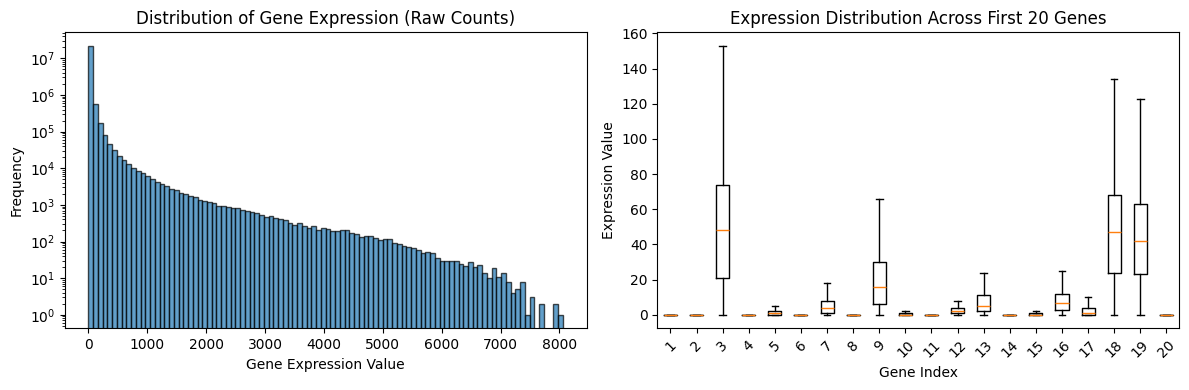

In [ ]:
# Explore the distribution of gene expression values
print("Gene expression statistics (before transformation):")
print(f"  Min: {gene_expression_data.min():.2f}")
print(f"  Max: {gene_expression_data.max():.2f}")
print(f"  Mean: {gene_expression_data.mean():.2f}")
print(f"  Median: {np.median(gene_expression_data):.2f}")
print(f"  Std: {gene_expression_data.std():.2f}")

# Check for zeros (important for log transformation)
num_zeros = (gene_expression_data == 0).sum()
print(
    f"\nNumber of zero values: {num_zeros:,} ({100 * num_zeros / gene_expression_data.size:.2f}% of data)"
)

# Visualize distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(gene_expression_data.flatten(), bins=100, edgecolor="black", alpha=0.7)
axes[0].set_xlabel("Gene Expression Value")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Distribution of Gene Expression (Raw Counts)")
axes[0].set_yscale("log")

axes[1].boxplot(
    [gene_expression_data[:, i] for i in range(min(20, gene_expression_data.shape[1]))],
    showfliers=False,
)
axes[1].set_xlabel("Gene Index")
axes[1].set_ylabel("Expression Value")
axes[1].set_title("Expression Distribution Across First 20 Genes")
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

### Apply Log Transformation

Log transformation is standard in RNA-seq analysis to:
- Normalize the scale of expression values
- Reduce impact of outliers
- Make the distribution more Gaussian-like
- Improve model training (lower loss values)

Gene expression statistics (after log1p transformation):
  Min: 0.00
  Max: 8.99
  Mean: 1.23
  Median: 0.69
  Std: 1.52
  Median: 0.69
  Std: 1.52


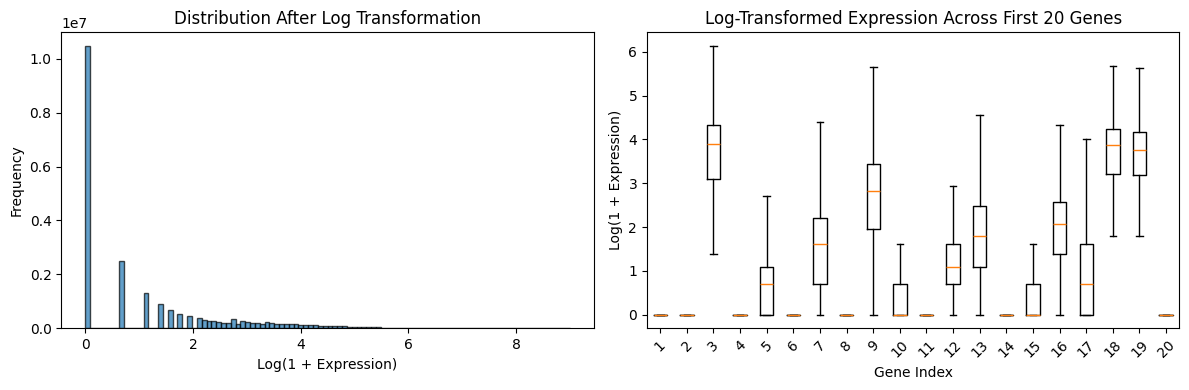


✓ Gene expression data has been log-transformed!
  Shape remains: (6744, 3407)


In [ ]:
# Apply log1p transformation (log(1 + x))
# log1p handles zeros gracefully: log(1 + 0) = 0
gene_expression_data_log = np.log1p(gene_expression_data)

print("Gene expression statistics (after log1p transformation):")
print(f"  Min: {gene_expression_data_log.min():.2f}")
print(f"  Max: {gene_expression_data_log.max():.2f}")
print(f"  Mean: {gene_expression_data_log.mean():.2f}")
print(f"  Median: {np.median(gene_expression_data_log):.2f}")
print(f"  Std: {gene_expression_data_log.std():.2f}")

# Visualize transformed distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(gene_expression_data_log.flatten(), bins=100, edgecolor="black", alpha=0.7)
axes[0].set_xlabel("Log(1 + Expression)")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Distribution After Log Transformation")

axes[1].boxplot(
    [
        gene_expression_data_log[:, i]
        for i in range(min(20, gene_expression_data_log.shape[1]))
    ],
    showfliers=False,
)
axes[1].set_xlabel("Gene Index")
axes[1].set_ylabel("Log(1 + Expression)")
axes[1].set_title("Log-Transformed Expression Across First 20 Genes")
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

# Update the gene_expression_data variable to use log-transformed values
gene_expression_data = gene_expression_data_log
print("\n✓ Gene expression data has been log-transformed!")
print(f"  Shape remains: {gene_expression_data.shape}")

## Initialize Model and Training Setup

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Get dimensions
input_dim = drug_features.shape[1]  # Number of molecular features
output_dim = gene_expression_data.shape[1]  # Number of genes

print("\nModel configuration:")
print(f"  Input dimension: {input_dim} (molecular descriptors)")
print(f"  Output dimension: {output_dim} (gene expression values)")

# Initialize model
model = SimpleMLP(
    input_dim=input_dim,
    output_dim=output_dim,
    hidden_dims=[512, 256, 128],  # Three hidden layers
    dropout_rate=0.3,
)
model = model.to(device)

print("\nModel architecture:")
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Using device: cpu

Model configuration:
  Input dimension: 768 (molecular descriptors)
  Output dimension: 3407 (gene expression values)

Model architecture:
SimpleMLP(
  (network): Sequential(
    (0): Linear(in_features=768, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=128, out_features=3407, bias=True)
  )
)

Total parameters: 999,247
Trainable parameters: 999,247


In [ ]:
# Create data loaders
train_loader, val_loader, train_idx, val_idx = create_data_loaders(
    drug_features=drug_features,
    gene_expression=gene_expression_data,
    drug_ids=drug_ids,
    train_size=0.8,
    batch_size=32,
    random_state=42,
)

print(f"Training samples: {len(train_idx)}")
print(f"Validation samples: {len(val_idx)}")
print(f"Batches per epoch (train): {len(train_loader)}")
print(f"Batches per epoch (val): {len(val_loader)}")

Training samples: 5395
Validation samples: 1349
Batches per epoch (train): 169
Batches per epoch (val): 43


In [ ]:
# Set up training
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=5
)

print("Training setup complete!")
print("Loss function: MSE Loss")
print("Optimizer: Adam (lr=0.001, weight_decay=1e-5)")
print("Learning rate scheduler: ReduceLROnPlateau")

Training setup complete!
Loss function: MSE Loss
Optimizer: Adam (lr=0.001, weight_decay=1e-5)
Learning rate scheduler: ReduceLROnPlateau


### 📊 Ready to Train!

**Model Summary:**
- Input: 768 molecular features (MolFormer embeddings)
- Output: 3,407 gene expression values
- Architecture: 768 → 512 → 256 → 128 → 3407
- Training samples: ~6,000
- Validation samples: ~1,500

The model now uses **pre-computed MolFormer embeddings** from a transformer-based molecular model! 🎉

## Training Loop

In [ ]:
# Training loop
num_epochs = 50
best_val_loss = float("inf")
train_losses = []
val_losses = []

print("Starting training...\n")

for epoch in range(num_epochs):
    # Train
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)

    # Validate
    val_loss = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)

    # Learning rate scheduling
    scheduler.step(val_loss)

    # Print progress
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(
            f"Epoch [{epoch + 1}/{num_epochs}] | "
            f"Train Loss: {train_loss:.4f} | "
            f"Val Loss: {val_loss:.4f}"
        )

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(
            {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "train_loss": train_loss,
                "val_loss": val_loss,
            },
            "best_model.pth",
        )

print(f"\nTraining complete! Best validation loss: {best_val_loss:.4f}")

Starting training...

Epoch [1/50] | Train Loss: 1.1141 | Val Loss: 0.6815
Epoch [1/50] | Train Loss: 1.1141 | Val Loss: 0.6815
Epoch [5/50] | Train Loss: 0.5817 | Val Loss: 0.5888
Epoch [5/50] | Train Loss: 0.5817 | Val Loss: 0.5888
Epoch [10/50] | Train Loss: 0.5160 | Val Loss: 0.5622
Epoch [10/50] | Train Loss: 0.5160 | Val Loss: 0.5622
Epoch [15/50] | Train Loss: 0.4767 | Val Loss: 0.5197
Epoch [15/50] | Train Loss: 0.4767 | Val Loss: 0.5197
Epoch [20/50] | Train Loss: 0.4519 | Val Loss: 0.5134
Epoch [20/50] | Train Loss: 0.4519 | Val Loss: 0.5134
Epoch [25/50] | Train Loss: 0.4368 | Val Loss: 0.5035
Epoch [25/50] | Train Loss: 0.4368 | Val Loss: 0.5035
Epoch [30/50] | Train Loss: 0.4196 | Val Loss: 0.4994
Epoch [30/50] | Train Loss: 0.4196 | Val Loss: 0.4994
Epoch [35/50] | Train Loss: 0.4134 | Val Loss: 0.4983
Epoch [35/50] | Train Loss: 0.4134 | Val Loss: 0.4983
Epoch [40/50] | Train Loss: 0.3850 | Val Loss: 0.4974
Epoch [40/50] | Train Loss: 0.3850 | Val Loss: 0.4974
Epoch [45/

## Visualize Training Progress

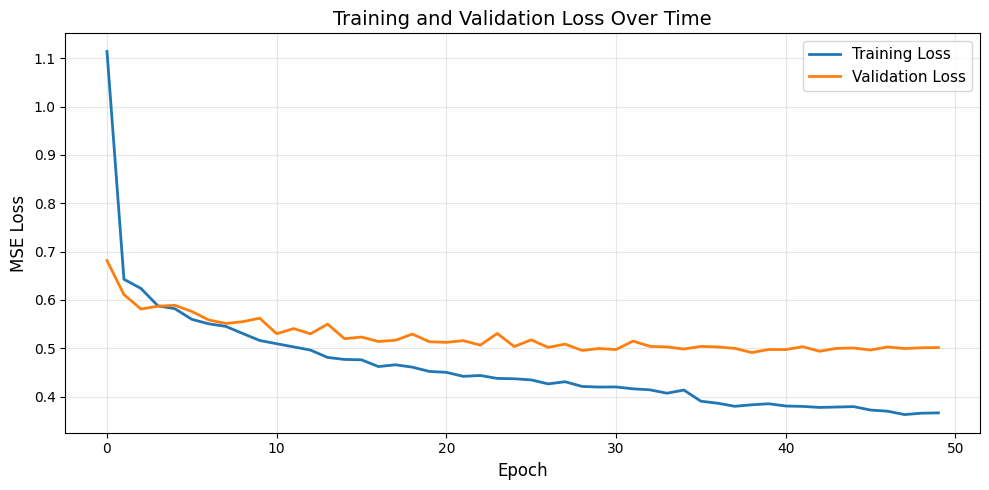

Final training loss: 0.3661
Final validation loss: 0.5013
Best validation loss: 0.4910


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss", linewidth=2)
plt.plot(val_losses, label="Validation Loss", linewidth=2)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("MSE Loss", fontsize=12)
plt.title("Training and Validation Loss Over Time", fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Final training loss: {train_losses[-1]:.4f}")
print(f"Final validation loss: {val_losses[-1]:.4f}")
print(f"Best validation loss: {best_val_loss:.4f}")

## Make Predictions

Test the model on validation data and analyze predictions.

In [ ]:
# Load best model
checkpoint = torch.load("best_model.pth")
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

# Make predictions on validation set
all_predictions = []
all_targets = []

with torch.no_grad():
    for batch_data in val_loader:
        # Handle both 2-tuple and 3-tuple returns from dataset
        if len(batch_data) == 3:
            batch_features, batch_targets, _ = batch_data
        else:
            batch_features, batch_targets = batch_data

        batch_features = batch_features.to(device)
        predictions = model(batch_features)

        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(batch_targets.numpy())

# Concatenate all batches
predictions = np.vstack(all_predictions)
targets = np.vstack(all_targets)

print(f"Predictions shape: {predictions.shape}")
print(f"Targets shape: {targets.shape}")


# Calculate R² and MAE for each gene
r2_scores = [
    r2_score(targets[:, i], predictions[:, i]) for i in range(targets.shape[1])
]
mae_scores = [
    mean_absolute_error(targets[:, i], predictions[:, i])
    for i in range(targets.shape[1])
]

print("\nOverall metrics:")
print(f"Mean R² score: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")
print(f"Mean MAE: {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")
print(f"Median R² score: {np.median(r2_scores):.4f}")
print(f"Best R² score: {np.max(r2_scores):.4f}")

Predictions shape: (1349, 3407)
Targets shape: (1349, 3407)

Overall metrics:
Mean R² score: 0.1052 ± 0.1121
Mean MAE: 0.4603 ± 0.2730
Median R² score: 0.0989
Best R² score: 0.4069

Overall metrics:
Mean R² score: 0.1052 ± 0.1121
Mean MAE: 0.4603 ± 0.2730
Median R² score: 0.0989
Best R² score: 0.4069


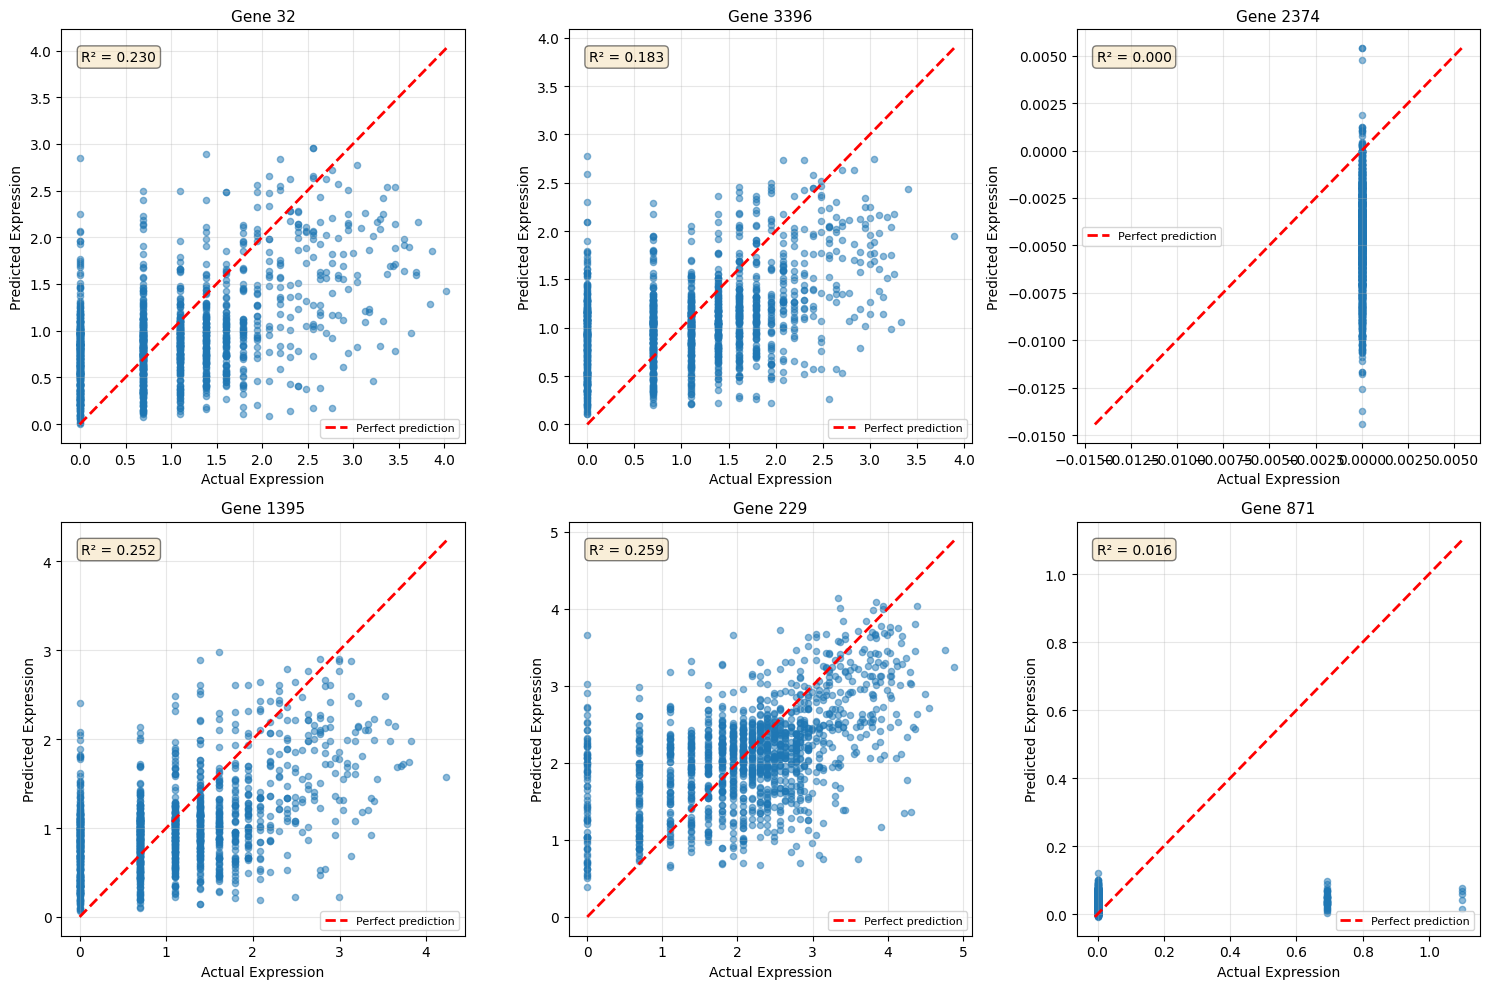

In [ ]:
# Visualize predictions vs actual for a sample of genes
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Select 6 random genes to visualize
np.random.seed(42)
gene_indices = np.random.choice(targets.shape[1], 6, replace=False)

for idx, gene_idx in enumerate(gene_indices):
    ax = axes[idx]

    # Scatter plot
    ax.scatter(targets[:, gene_idx], predictions[:, gene_idx], alpha=0.5, s=20)

    # Add perfect prediction line
    min_val = min(targets[:, gene_idx].min(), predictions[:, gene_idx].min())
    max_val = max(targets[:, gene_idx].max(), predictions[:, gene_idx].max())
    ax.plot(
        [min_val, max_val],
        [min_val, max_val],
        "r--",
        linewidth=2,
        label="Perfect prediction",
    )

    # Add R² score
    r2 = r2_score(targets[:, gene_idx], predictions[:, gene_idx])
    ax.text(
        0.05,
        0.95,
        f"R² = {r2:.3f}",
        transform=ax.transAxes,
        verticalalignment="top",
        fontsize=10,
        bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5),
    )

    ax.set_xlabel("Actual Expression", fontsize=10)
    ax.set_ylabel("Predicted Expression", fontsize=10)
    ax.set_title(f"Gene {gene_idx}", fontsize=11)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()